In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2DTranspose, Concatenate, Input, GlobalAveragePooling2D, Dense, BatchNormalization, MaxPooling2D,Flatten, Dropout, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras import layers, regularizers
from tensorflow.keras.applications import EfficientNetB0, InceptionV3, DenseNet121,ResNet50,VGG16,DenseNet169,EfficientNetB5
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import glob


# Loading the dataset


In [ ]:
import kagglehub
img_size=(250,250)
batch_size=184

dataset_path = kagglehub.dataset_download("ananthu017/emotion-detection-fer")

print("Path to dataset files:", dataset_path)

Using Colab cache for faster access to the 'emotion-detection-fer' dataset.
Path to dataset files: /kaggle/input/emotion-detection-fer


# Collecting Dataset Image Paths

In [ ]:
image_files = glob.glob(os.path.join(dataset_path, "**", "*.jpg"), recursive=True)
image_files += glob.glob(os.path.join(dataset_path, "**", "*.png"), recursive=True)

# Preparing Dataset with Filepaths and Labels

In [ ]:
data = []
for f in image_files:
    label = os.path.basename(os.path.dirname(f))
    data.append([f, label])

df = pd.DataFrame(data, columns=["filepath", "label"])
print("Images found:", len(df))
print("Class distribution:\n", df["label"].value_counts())

Images found: 35887
Class distribution:
 label
happy        8989
neutral      6198
sad          6077
fearful      5121
angry        4953
surprised    4002
disgusted     547
Name: count, dtype: int64


# Handling Class Imbalance with Oversampling

In [ ]:
max_count = df["label"].value_counts().max()
df_balanced = df.groupby("label", group_keys=False).apply(
    lambda x: x.sample(max_count, replace=True, random_state=42)
).reset_index(drop=True)

print("Balanced distribution:\n", df_balanced["label"].value_counts())

Balanced distribution:
 label
angry        8989
disgusted    8989
fearful      8989
happy        8989
neutral      8989
sad          8989
surprised    8989
Name: count, dtype: int64


/tmp/ipython-input-3389815314.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby("label", group_keys=False).apply(


# Splitting Data into Training and Validation Sets

In [ ]:
train_df, val_df = train_test_split(
    df_balanced,
    test_size=0.2,
    stratify=df_balanced["label"],
    random_state=42
)
print("Train size:", len(train_df), "Val size:", len(val_df))

Train size: 50338 Val size: 12585


# Preparing Training and Validation Data

In [ ]:
train_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    target_size=img_size,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
    subset='training',
    shuffle=True,
)

val_data = train_gen.flow_from_dataframe(
    val_df,
    x_col='filepath',
    y_col='label',
    target_size=img_size,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
    subset='validation',
    shuffle=False,
)


Found 40271 validated image filenames belonging to 7 classes.
Found 2517 validated image filenames belonging to 7 classes.


# Building the AlexNet-Like Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_alexnet_like(input_shape=(250, 250, 1), num_classes=7):
    inputs = layers.Input(shape=input_shape)
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
    ])
    x = data_augmentation(inputs)

    x = layers.Conv2D(96, 11, strides=4, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(3, strides=2)(x)
    x = layers.Dropout(0.35)(x)

    x = layers.Conv2D(256, 5, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(3, strides=2)(x)
    x = layers.Dropout(0.35)(x)

    x = layers.Conv2D(384, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(384, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(3, strides=2)(x)
    x = layers.Dropout(0.35)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(524, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

IMG_SIZE = (250, 250)
NUM_CLASSES = 7

model = build_alexnet_like(input_shape=IMG_SIZE + (1,), num_classes=NUM_CLASSES)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 250, 250, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 60, 60, 96)     │        11,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 60, 60, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 29, 29, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 29, 29, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 29, 29, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 524)            │     4,829,708 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 524)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,675 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,558,759 (32.65 MB)

 Trainable params: 8,558,055 (32.65 MB)

 Non-trainable params: 704 (2.75 KB)

# Setting Up Training Callbacks

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=6,
        restore_best_weights=True,
        verbose=1
    ),

    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=2,
        verbose=1,
    ),

    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_emotion_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]


# Training the Model

In [ ]:
history = model.fit(train_data,validation_data=val_data,epochs=80,callbacks=callbacks)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 702ms/step - accuracy: 0.1843 - loss: 2.1600
Epoch 1: val_accuracy improved from -inf to 0.15296, saving model to best_emotion_model.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 206s 803ms/step - accuracy: 0.1845 - loss: 2.1591 - val_accuracy: 0.1530 - val_loss: 2.0359 - learning_rate: 1.0000e-04
Epoch 2/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.2866 - loss: 1.7983
Epoch 2: val_accuracy improved from 0.15296 to 0.23004, saving model to best_emotion_model.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 67s 307ms/step - accuracy: 0.2868 - loss: 1.7981 - val_accuracy: 0.2300 - val_loss: 1.8923 - learning_rate: 1.0000e-04
Epoch 3/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.3947 - loss: 1.5887
Epoch 3: val_accuracy improved from 0.23004 to 0.42829, saving model to best_emotion_model.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 70s 320ms/step - accuracy: 0.3948 - loss: 1.5885 - val_accuracy: 0.4283 - val_loss: 1.5446 - learning_rate: 1.0000e-04
Epoch 4/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.4798 - loss: 1.3816
Epoch 4: val_accuracy improved from 0.42829 to 0.52880, saving model to best_emotion_model.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 69s 314ms/step - accuracy: 0.4799 - loss: 1.3815 - val_accuracy: 0.5288 - val_loss: 1.2844 - learning_rate: 1.0000e-04
Epoch 5/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.5332 - loss: 1.2518
Epoch 5: val_accuracy improved from 0.52880 to 0.57727, saving model to best_emotion_model.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 69s 314ms/step - accuracy: 0.5333 - loss: 1.2517 - val_accuracy: 0.5773 - val_loss: 1.1359 - learning_rate: 1.0000e-04
Epoch 6/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.5820 - loss: 1.1255
Epoch 6: val_accuracy improved from 0.57727 to 0.63607, saving model to best_emotion_model.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 68s 309ms/step - accuracy: 0.5821 - loss: 1.1255 - val_accuracy: 0.6361 - val_loss: 0.9990 - learning_rate: 1.0000e-04
Epoch 7/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.6246 - loss: 1.0175
Epoch 7: val_accuracy improved from 0.63607 to 0.64323, saving model to best_emotion_model.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 66s 300ms/step - accuracy: 0.6246 - loss: 1.0175 - val_accuracy: 0.6432 - val_loss: 0.9788 - learning_rate: 1.0000e-04
Epoch 8/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.6584 - loss: 0.9271
Epoch 8: val_accuracy improved from 0.64323 to 0.69646, saving model to best_emotion_model.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 71s 322ms/step - accuracy: 0.6584 - loss: 0.9271 - val_accuracy: 0.6965 - val_loss: 0.8728 - learning_rate: 1.0000e-04
Epoch 9/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.6900 - loss: 0.8474
Epoch 9: val_accuracy improved from 0.69646 to 0.70004, saving model to best_emotion_model.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 73s 334ms/step - accuracy: 0.6900 - loss: 0.8473 - val_accuracy: 0.7000 - val_loss: 0.8378 - learning_rate: 1.0000e-04
Epoch 10/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.7192 - loss: 0.7685
Epoch 10: val_accuracy improved from 0.70004 to 0.75050, saving model to best_emotion_model.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 77s 351ms/step - accuracy: 0.7192 - loss: 0.7685 - val_accuracy: 0.7505 - val_loss: 0.7471 - learning_rate: 1.0000e-04
Epoch 11/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.7511 - loss: 0.6962
Epoch 11: val_accuracy improved from 0.75050 to 0.77235, saving model to best_emotion_model.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 76s 346ms/step - accuracy: 0.7510 - loss: 0.6963 - val_accuracy: 0.7723 - val_loss: 0.7190 - learning_rate: 1.0000e-04
Epoch 12/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.7754 - loss: 0.6212
Epoch 12: val_accuracy improved from 0.77235 to 0.78903, saving model to best_emotion_model.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 76s 344ms/step - accuracy: 0.7754 - loss: 0.6213 - val_accuracy: 0.7890 - val_loss: 0.6364 - learning_rate: 1.0000e-04
Epoch 13/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.7994 - loss: 0.5650
Epoch 13: val_accuracy improved from 0.78903 to 0.79340, saving model to best_emotion_model.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 77s 353ms/step - accuracy: 0.7994 - loss: 0.5650 - val_accuracy: 0.7934 - val_loss: 0.6161 - learning_rate: 1.0000e-04
Epoch 14/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.8147 - loss: 0.5171
Epoch 14: val_accuracy improved from 0.79340 to 0.81724, saving model to best_emotion_model.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 77s 352ms/step - accuracy: 0.8147 - loss: 0.5170 - val_accuracy: 0.8172 - val_loss: 0.5741 - learning_rate: 1.0000e-04
Epoch 15/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.8373 - loss: 0.4608
Epoch 15: val_accuracy did not improve from 0.81724
219/219 ━━━━━━━━━━━━━━━━━━━━ 77s 351ms/step - accuracy: 0.8373 - loss: 0.4608 - val_accuracy: 0.7966 - val_loss: 0.6079 - learning_rate: 1.0000e-04
Epoch 16/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.8488 - loss: 0.4243
Epoch 16: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 16: val_accuracy did not improve from 0.81724
219/219 ━━━━━━━━━━━━━━━━━━━━ 78s 354ms/step - accuracy: 0.8488 - loss: 0.4243 - val_accuracy: 0.7716 - val_loss: 0.6806 - learning_rate: 1.0000e-04
Epoch 17/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.8763 - loss: 0.3495
Epoch 17: val_accuracy improved from 0.81724 to 0.85340, saving model to best_emotion_model.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 75s 344ms/step - accuracy: 0.8763 - loss: 0.3495 - val_accuracy: 0.8534 - val_loss: 0.4850 - learning_rate: 5.0000e-05
Epoch 18/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.8901 - loss: 0.3085
Epoch 18: val_accuracy improved from 0.85340 to 0.85975, saving model to best_emotion_model.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 82s 342ms/step - accuracy: 0.8901 - loss: 0.3085 - val_accuracy: 0.8598 - val_loss: 0.4675 - learning_rate: 5.0000e-05
Epoch 19/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.9007 - loss: 0.2815
Epoch 19: val_accuracy did not improve from 0.85975
219/219 ━━━━━━━━━━━━━━━━━━━━ 72s 326ms/step - accuracy: 0.9007 - loss: 0.2815 - val_accuracy: 0.8427 - val_loss: 0.5191 - learning_rate: 5.0000e-05
Epoch 20/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.9070 - loss: 0.2694
Epoch 20: val_accuracy improved from 0.85975 to 0.86730, saving model to best_emotion_model.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 72s 326ms/step - accuracy: 0.9070 - loss: 0.2694 - val_accuracy: 0.8673 - val_loss: 0.4563 - learning_rate: 5.0000e-05
Epoch 21/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.9110 - loss: 0.2534
Epoch 21: val_accuracy improved from 0.86730 to 0.86770, saving model to best_emotion_model.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 72s 327ms/step - accuracy: 0.9110 - loss: 0.2534 - val_accuracy: 0.8677 - val_loss: 0.4618 - learning_rate: 5.0000e-05
Epoch 22/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.9181 - loss: 0.2335
Epoch 22: val_accuracy improved from 0.86770 to 0.87406, saving model to best_emotion_model.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 73s 331ms/step - accuracy: 0.9181 - loss: 0.2335 - val_accuracy: 0.8741 - val_loss: 0.4640 - learning_rate: 5.0000e-05
Epoch 23/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.9238 - loss: 0.2215
Epoch 23: val_accuracy did not improve from 0.87406
219/219 ━━━━━━━━━━━━━━━━━━━━ 77s 306ms/step - accuracy: 0.9238 - loss: 0.2215 - val_accuracy: 0.8713 - val_loss: 0.4590 - learning_rate: 5.0000e-05
Epoch 24/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.9262 - loss: 0.2115
Epoch 24: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 24: val_accuracy did not improve from 0.87406
219/219 ━━━━━━━━━━━━━━━━━━━━ 73s 330ms/step - accuracy: 0.9262 - loss: 0.2115 - val_accuracy: 0.8594 - val_loss: 0.4878 - learning_rate: 5.0000e-05
Epoch 25/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.9360 - loss: 0.1904
Epoch 25: val_accuracy improved from 0.87406 to 0.87565, saving model to best_emotion_model.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 75s 340ms/step - accuracy: 0.9360 - loss: 0.1904 - val_accuracy: 0.8756 - val_loss: 0.4508 - learning_rate: 2.5000e-05
Epoch 26/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.9397 - loss: 0.1726
Epoch 26: val_accuracy did not improve from 0.87565
219/219 ━━━━━━━━━━━━━━━━━━━━ 75s 339ms/step - accuracy: 0.9397 - loss: 0.1726 - val_accuracy: 0.8756 - val_loss: 0.4487 - learning_rate: 2.5000e-05
Epoch 27/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.9445 - loss: 0.1609
Epoch 27: val_accuracy improved from 0.87565 to 0.87644, saving model to best_emotion_model.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 82s 341ms/step - accuracy: 0.9445 - loss: 0.1609 - val_accuracy: 0.8764 - val_loss: 0.4480 - learning_rate: 2.5000e-05
Epoch 28/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.9485 - loss: 0.1561
Epoch 28: val_accuracy improved from 0.87644 to 0.87843, saving model to best_emotion_model.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 82s 344ms/step - accuracy: 0.9485 - loss: 0.1561 - val_accuracy: 0.8784 - val_loss: 0.4520 - learning_rate: 2.5000e-05
Epoch 29/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.9460 - loss: 0.1554
Epoch 29: val_accuracy did not improve from 0.87843
219/219 ━━━━━━━━━━━━━━━━━━━━ 75s 343ms/step - accuracy: 0.9460 - loss: 0.1554 - val_accuracy: 0.8768 - val_loss: 0.4479 - learning_rate: 2.5000e-05
Epoch 30/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.9481 - loss: 0.1516
Epoch 30: val_accuracy improved from 0.87843 to 0.87962, saving model to best_emotion_model.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 76s 344ms/step - accuracy: 0.9481 - loss: 0.1516 - val_accuracy: 0.8796 - val_loss: 0.4422 - learning_rate: 2.5000e-05
Epoch 31/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.9504 - loss: 0.1432
Epoch 31: val_accuracy improved from 0.87962 to 0.88280, saving model to best_emotion_model.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 74s 336ms/step - accuracy: 0.9504 - loss: 0.1432 - val_accuracy: 0.8828 - val_loss: 0.4448 - learning_rate: 2.5000e-05
Epoch 32/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.9525 - loss: 0.1390
Epoch 32: val_accuracy did not improve from 0.88280
219/219 ━━━━━━━━━━━━━━━━━━━━ 74s 336ms/step - accuracy: 0.9524 - loss: 0.1390 - val_accuracy: 0.8788 - val_loss: 0.4351 - learning_rate: 2.5000e-05
Epoch 33/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.9555 - loss: 0.1323
Epoch 33: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 33: val_accuracy did not improve from 0.88280
219/219 ━━━━━━━━━━━━━━━━━━━━ 73s 333ms/step - accuracy: 0.9555 - loss: 0.1323 - val_accuracy: 0.8808 - val_loss: 0.4485 - learning_rate: 2.5000e-05
Epoch 34/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.9574 - loss: 0.1275
Epoch 34: val_accuracy did not improve from 0.88280
219/219 ━━━━━━━━━━━━━━━━━━━━ 76s 346ms/step - accuracy:

219/219 ━━━━━━━━━━━━━━━━━━━━ 71s 323ms/step - accuracy: 0.9617 - loss: 0.1144 - val_accuracy: 0.8856 - val_loss: 0.4491 - learning_rate: 6.2500e-06
Epoch 38/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.9625 - loss: 0.1086
Epoch 38: val_accuracy improved from 0.88558 to 0.88598, saving model to best_emotion_model.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 73s 331ms/step - accuracy: 0.9625 - loss: 0.1086 - val_accuracy: 0.8860 - val_loss: 0.4489 - learning_rate: 6.2500e-06
Epoch 39/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.9623 - loss: 0.1121
Epoch 39: val_accuracy did not improve from 0.88598
219/219 ━━━━━━━━━━━━━━━━━━━━ 81s 327ms/step - accuracy: 0.9623 - loss: 0.1121 - val_accuracy: 0.8812 - val_loss: 0.4449 - learning_rate: 6.2500e-06
Epoch 40/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.9644 - loss: 0.1056
Epoch 40: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 40: val_accuracy did not improve from 0.88598
219/219 ━━━━━━━━━━━━━━━━━━━━ 71s 323ms/step - accuracy: 0.9643 - loss: 0.1057 - val_accuracy: 0.8832 - val_loss: 0.4496 - learning_rate: 6.2500e-06
Epoch 41/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.9614 - loss: 0.1108
Epoch 41: val_accuracy did not improve from 0.88598
219/219 ━━━━━━━━━━━━━━━━━━━━ 69s 312ms/step - accuracy: 

# Evaluating the Model

In [ ]:
test_loss, test_accuracy = model.evaluate(val_data)
print(f"Final Test Loss: {test_loss:.4f}")
print(f"Final Test Accuracy: {test_accuracy:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 294ms/step - accuracy: 0.8905 - loss: 0.4476
Final Test Loss: 0.4489
Final Test Accuracy: 0.8860


# Visualization of Model Predictions

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 417ms/step


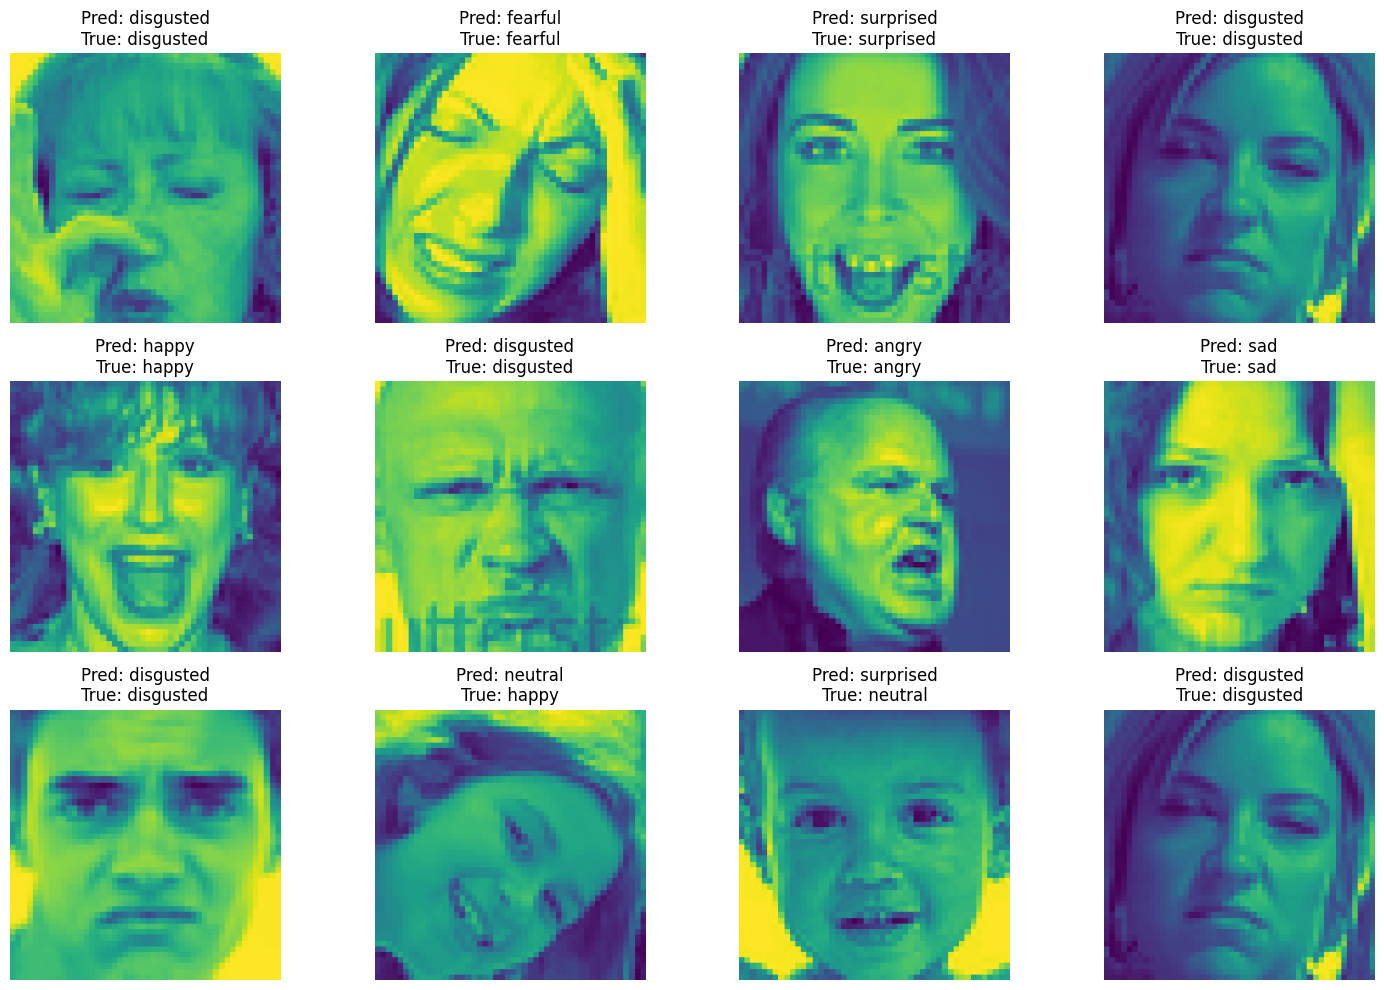

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

class_names = list(train_data.class_indices.keys())

image_batch, label_batch = next(iter(val_data))
predictions = model.predict(image_batch)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(label_batch, axis=1)

plt.figure(figsize=(15, 10))
for i in range(12):
    idx = random.randint(0, len(image_batch) - 1)
    plt.subplot(3, 4, i + 1)
    plt.imshow((image_batch[idx] * 255).astype("uint8"))
    plt.title(f"Pred: {class_names[predicted_labels[idx]]}\nTrue: {class_names[true_labels[idx]]}")
    plt.axis("off")

plt.tight_layout()
plt.show()


# Confusion Matrix Analysis

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 676ms/step


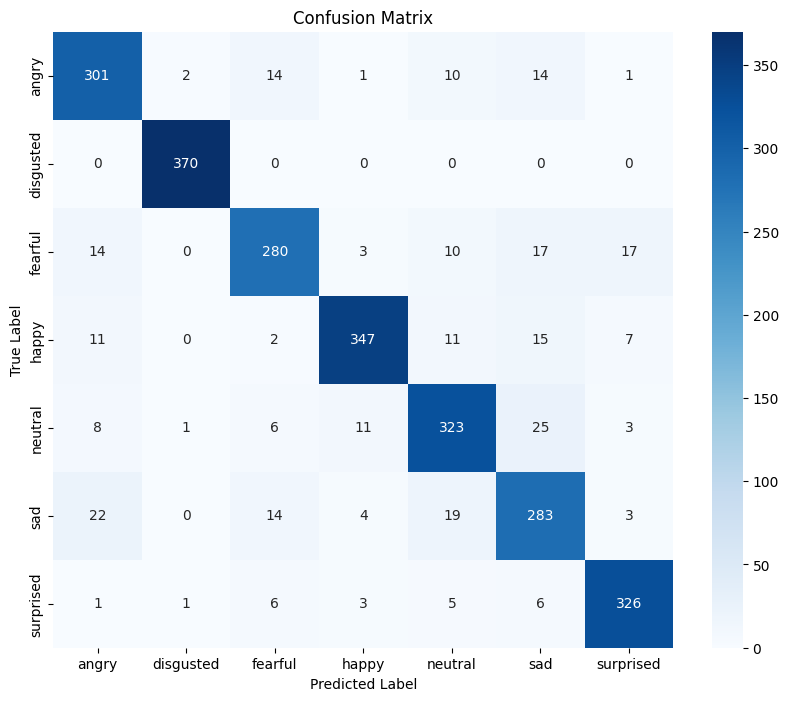

              precision    recall  f1-score   support

       angry       0.84      0.88      0.86       343
   disgusted       0.99      1.00      0.99       370
     fearful       0.87      0.82      0.84       341
       happy       0.94      0.88      0.91       393
     neutral       0.85      0.86      0.86       377
         sad       0.79      0.82      0.80       345
   surprised       0.91      0.94      0.92       348

    accuracy                           0.89      2517
   macro avg       0.89      0.89      0.88      2517
weighted avg       0.89      0.89      0.89      2517



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

class_names = list(train_data.class_indices.keys())

y_true = []
y_pred = []

val_data.reset()
for images, labels in val_data:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels, axis=1))
    if len(y_true) >= val_data.samples:
        break

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))


# Training & Validation Curves

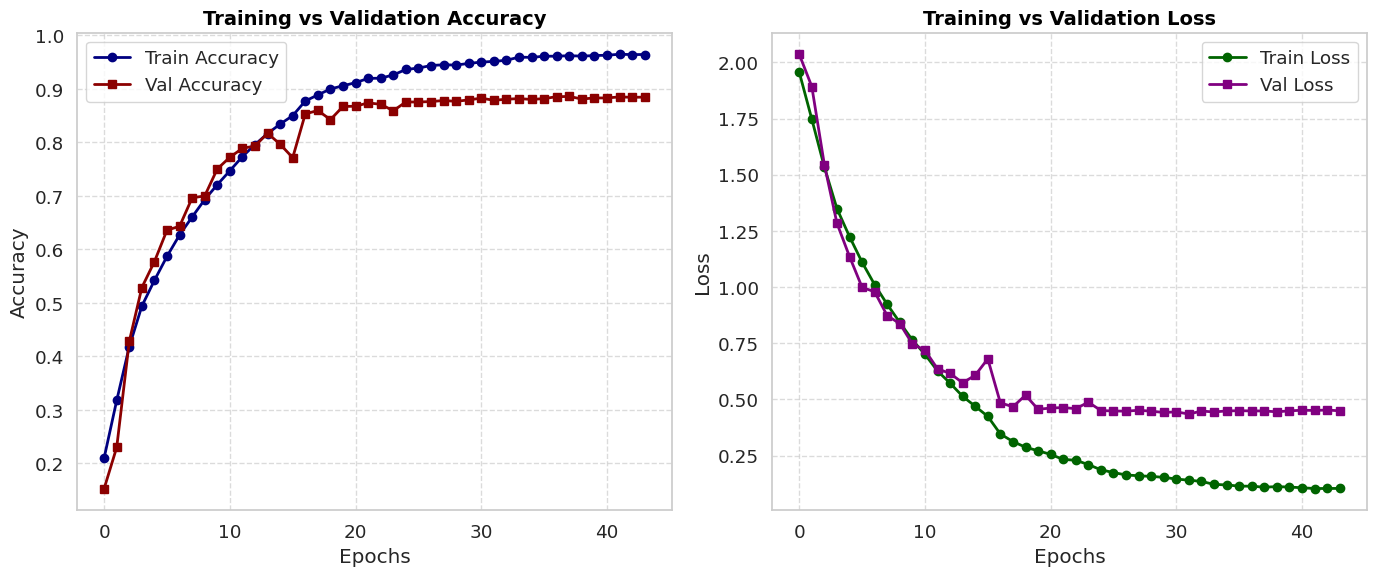

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.2)

history_dict = history.history

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.plot(history_dict['accuracy'], marker='o', linewidth=2, color='navy', label='Train Accuracy')
plt.plot(history_dict['val_accuracy'], marker='s', linewidth=2, color='darkred', label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy', fontsize=14, fontweight='bold', color='black')
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)

plt.subplot(1,2,2)
plt.plot(history_dict['loss'], marker='o', linewidth=2, color='darkgreen', label='Train Loss')
plt.plot(history_dict['val_loss'], marker='s', linewidth=2, color='purple', label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss', fontsize=14, fontweight='bold', color='black')
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()
